In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

import process_gini as pg
import plots

In [2]:
df = pd.read_csv("../data/skylab_instagram_datathon_dataset.csv", sep=";")

df.shape

(704313, 15)

In [3]:
# information about the data before processing it -> run again after processing
df.describe(include='all')

,period,period_end_date,compset_group,compset,business_entity_doing_business_as_name,legal_entity_name,domicile_country_name,ultimate_parent_legal_entity_name,primary_exchange_name,calculation_type,followers,pictures,videos,comments,likes
count,704313,704313,704313,704313,704313,676558,458589,676558,458589,704313,5.792580e+05,695803.000000,684349.000000,6.953430e+05,6.959770e+05
unique,1,455,20,54,706,423,26,401,30,1,NaN,NaN,NaN,NaN,NaN
top,Weekly,2023-07-08,Luxury & Premium & Mainstream,US Softlines Analyst Interest List,All Brands,LVMH Moet Hennessy Louis Vuitton SE,United States of America,LVMH Moet Hennessy Louis Vuitton SE,New York Stock Exchange,Metric Value,NaN,NaN,NaN,NaN,NaN
freq,704313,1635,216241,113744,27755,27576,193509,27576,132071,704313,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.342432e+07,344.272540,61.244426,3.043246e+04,2.163189e+06
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.106975e+08,2777.396873,564.468480,2.766459e+05,1.803193e+07
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.013372e+05,19.000000,2.000000,3.710000e+02,1.727700e+04
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.104144e+06,44.000000,7.000000,1.435000e+03,9.318400e+04
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.479325e+06,122.000000,20.000000,5.872000e+03,4.577470e+05


# Process data

## Data cleaing

### Replace

In [4]:
# READJUST STRINGS

# remove leading and trailing whitespaces and convert to lowercase
df = df.map(lambda x: x.strip().lower() if isinstance(x, str) else x)

# replace all double whitespaces with single whitespaces
df = df.map(lambda x: x.replace("  ", " ") if isinstance(x, str) else x)

In [5]:
# Converting the 'period_end_of_week' column to datetime
df['period_end_date'] = pd.to_datetime(df['period_end_date'])

In [6]:
# REPLACE DOMICILE_COUNTRY_NAME

# replace the china;hong kong with hong kong
df['domicile_country_name'] = df['domicile_country_name'].replace('china;hong kong', 'hong kong')

# remove the sign ";" in column domicile_country_name
df['domicile_country_name'] = df['domicile_country_name'].str.replace(';', '')

# if empty, fill with nan
df['domicile_country_name'] = df['domicile_country_name'].replace('', np.nan)

In [7]:
# REPLACE PRIMARY_EXCHANGE_NAME

# remove the sign ";" in column domicile_country_name
df['primary_exchange_name'] = df['primary_exchange_name'].str.replace(';', '')

# if empty, fill with nan
df['primary_exchange_name'] = df['primary_exchange_name'].replace('', np.nan)

In [8]:
# REPLACE ULTIMATE_PARENT_LEGAL_ENTITY_NAME
df['ultimate_parent_legal_entity_name'] = df['ultimate_parent_legal_entity_name'].replace('Anheuser-Busch;Anheuser-Busch', 'Anheuser-Busch')

### Remove

In [9]:
# Remove "All_Brands" and "Don't Use it"
df = df[df["business_entity_doing_business_as_name"] != "all brands"]
# TODO: Remove "Don't Use it"

In [10]:
# remove unnecessary columns
# Here: 'period', 'calculation_type'
df = df.drop(columns=['period', 'calculation_type'])

In [11]:
# certain entries have exact data except of "compset"
# we want to take the union of all of them

grouping_columns = [col for col in df.columns if col != 'compset']

df.fillna('Group_Null', inplace=True)
result = df.groupby(grouping_columns).agg({'compset': lambda x: set(x)}).reset_index()
df = result
df.replace('Group_Null', np.nan, inplace=True)


# df.describe(include='all')

# to test
#result[(result["business_entity_doing_business_as_name"] == "24S") & (result["period_end_date"] == "2017-05-13")]
#result[(result["business_entity_doing_business_as_name"] == "dd's Discounts") & (result["period_end_date"] == "2023-09-09")]
#result[(result["business_entity_doing_business_as_name"] == "dd's Discounts") & (result["period_end_date"] == "2023-09-16")]

/tmp/ipykernel_38560/591243391.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Group_Null' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.fillna('Group_Null', inplace=True)
/tmp/ipykernel_38560/591243391.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace('Group_Null', np.nan, inplace=True)


In [12]:
result.shape

(298040, 13)

## Add features

In [13]:
# split the date into year, month, day
df['Year'] = df['period_end_date'].dt.year
df['Month'] = df['period_end_date'].dt.month
df['Day'] = df['period_end_date'].dt.day

In [14]:
# get the difference between the current date and the previous date
df = df.sort_values(by=['business_entity_doing_business_as_name', 'period_end_date'])
df['date_diff_prev'] = df['period_end_date'].diff().dt.days
df['date_diff_prev'] = df['date_diff_prev'].fillna(7)

In [15]:
# total involvement
df["total_involvement"] = df["comments"] + df["likes"]
df["total_company_activity"] = df["pictures"] + df["videos"]

df["conversion_rate_total"] = df["total_involvement"] / df["followers"]

# COntent type
df["ratio_of_videos"] = df["videos"] / (df["pictures"] + df["videos"])
df["ratio_of_pictures"] = df["pictures"] / (df["pictures"] + df["videos"])

# ASSUMTION: we only like videos / photos from this week
df["likes_per_picture"] = df["likes"] / df["pictures"]
df["likes_per_video"] =   df["likes"] / df["videos"]
df["comments_per_picture"] =  df["comments"] / df["pictures"] 
df["comments_per_video"] =   df["comments"] / df["videos"]

# take care of zeros
df.loc[df["pictures"] + df["videos"] == 0, "ratio_of_videos"] = np.nan
df.loc[df["pictures"] + df["videos"] == 0, "ratio_of_pictures"] = np.nan

df.loc[df["pictures"] == 0, "likes_per_picture"] = np.nan
df.loc[df["videos"] == 0, "likes_per_video"] = np.nan
df.loc[df["pictures"] == 0, "comments_per_picture"] = np.nan
df.loc[df["videos"] == 0, "comments_per_video"] = np.nan

In [16]:
# ADD GINI
reload(pg)

df_gini = pg.process_gini(df)
df = pd.merge(df, df_gini, left_on=['domicile_country_name', 'Year'], right_on=['Country Name', 'Year'], how="left")

In [17]:
df.columns

Index(['period_end_date', 'compset_group',
       'business_entity_doing_business_as_name', 'legal_entity_name',
       'domicile_country_name', 'ultimate_parent_legal_entity_name',
       'primary_exchange_name', 'followers', 'pictures', 'videos', 'comments',
       'likes', 'compset', 'Year', 'Month', 'Day', 'date_diff_prev',
       'total_involvement', 'total_company_activity', 'conversion_rate_total',
       'ratio_of_videos', 'ratio_of_pictures', 'likes_per_picture',
       'likes_per_video', 'comments_per_picture', 'comments_per_video',
       'Country Name', 'Gene Index'],
      dtype='object')

# Observations / Plots

## Total number of ... over time

In [18]:
agg_by = ['followers', 'pictures', 'videos', 'comments',
       'likes',
       'total_involvement', 'total_company_activity', 'conversion_rate_total',
       'ratio_of_videos', 'ratio_of_pictures', 'likes_per_picture',
       'likes_per_video', 'comments_per_picture', 'comments_per_video']

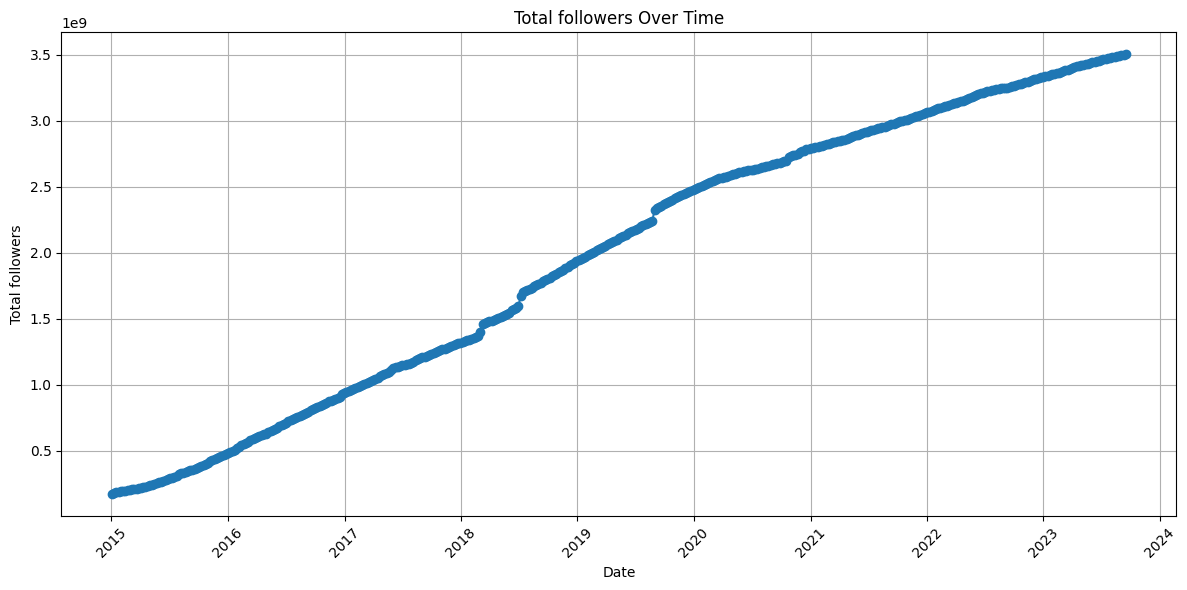

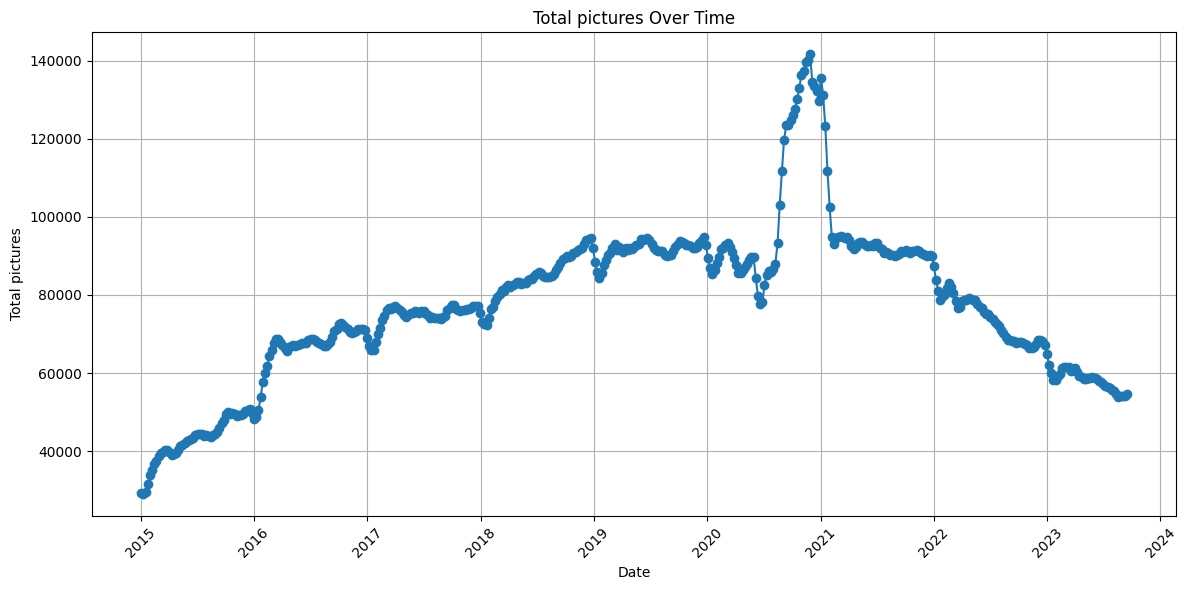

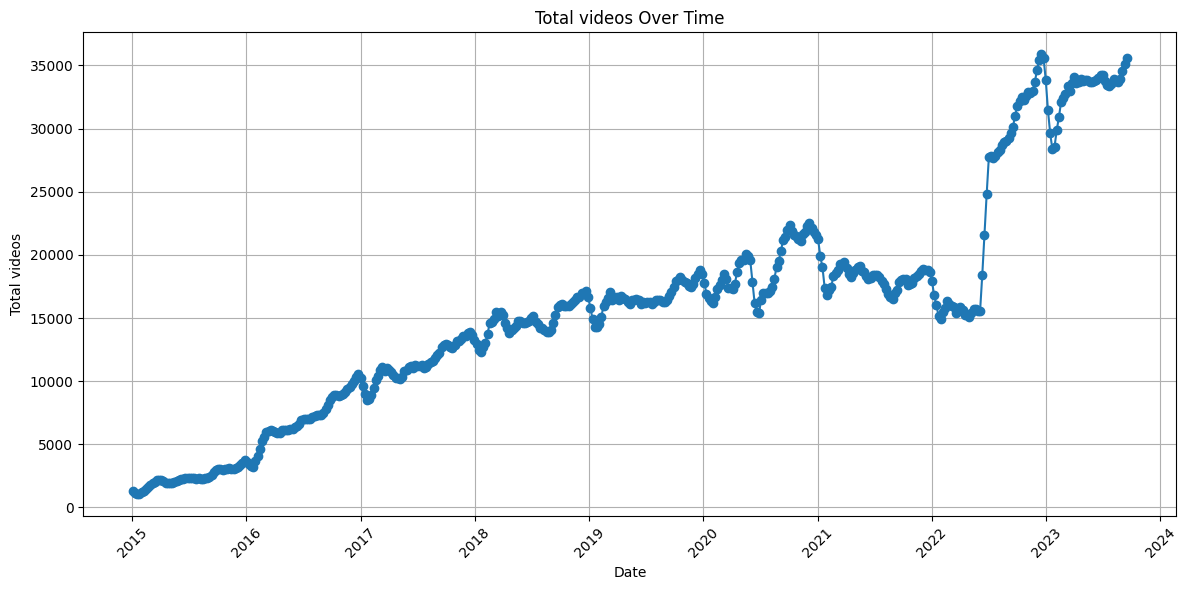

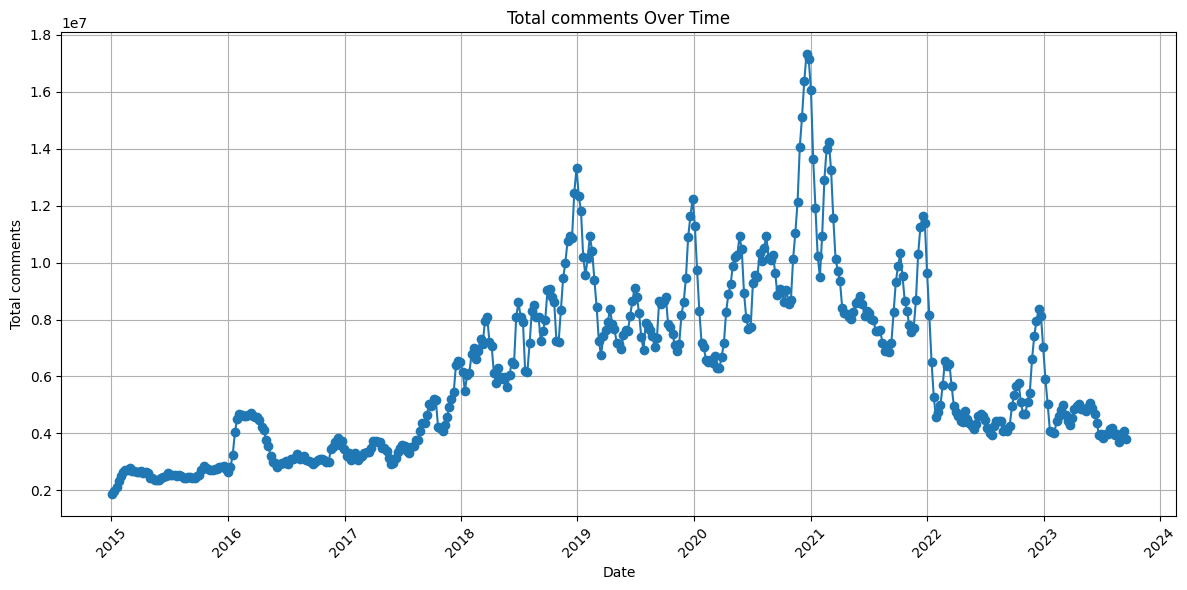

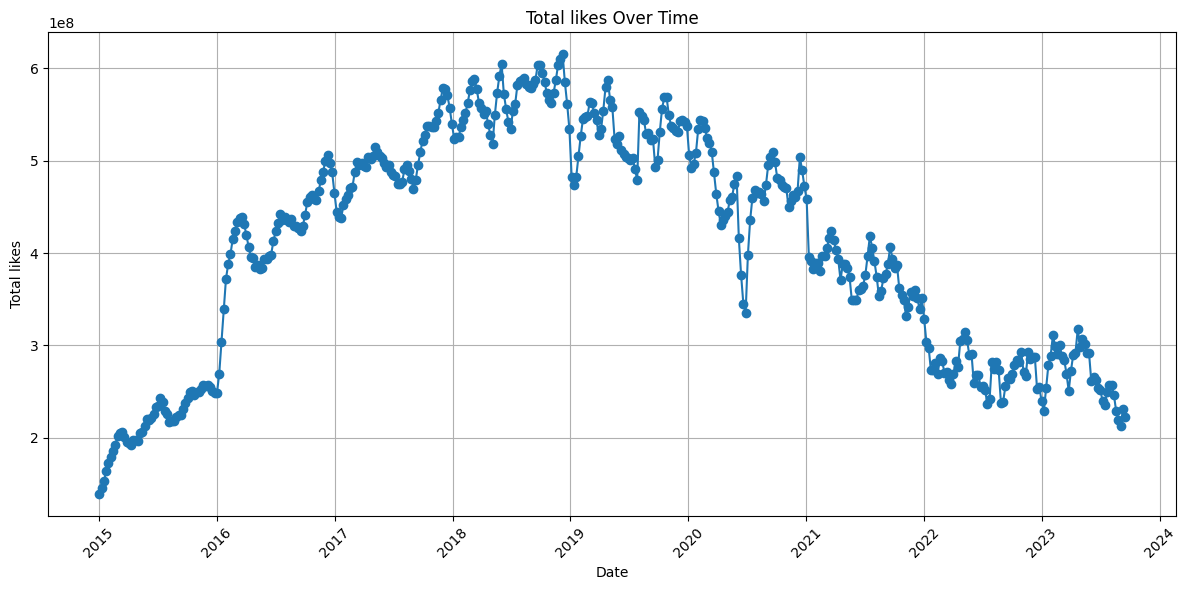

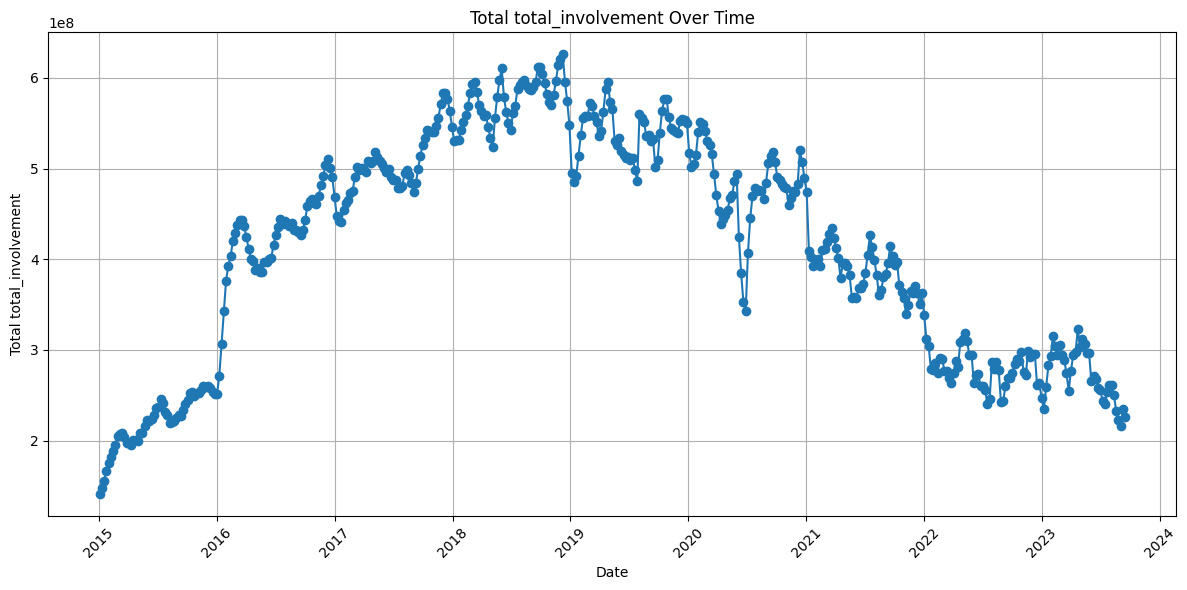

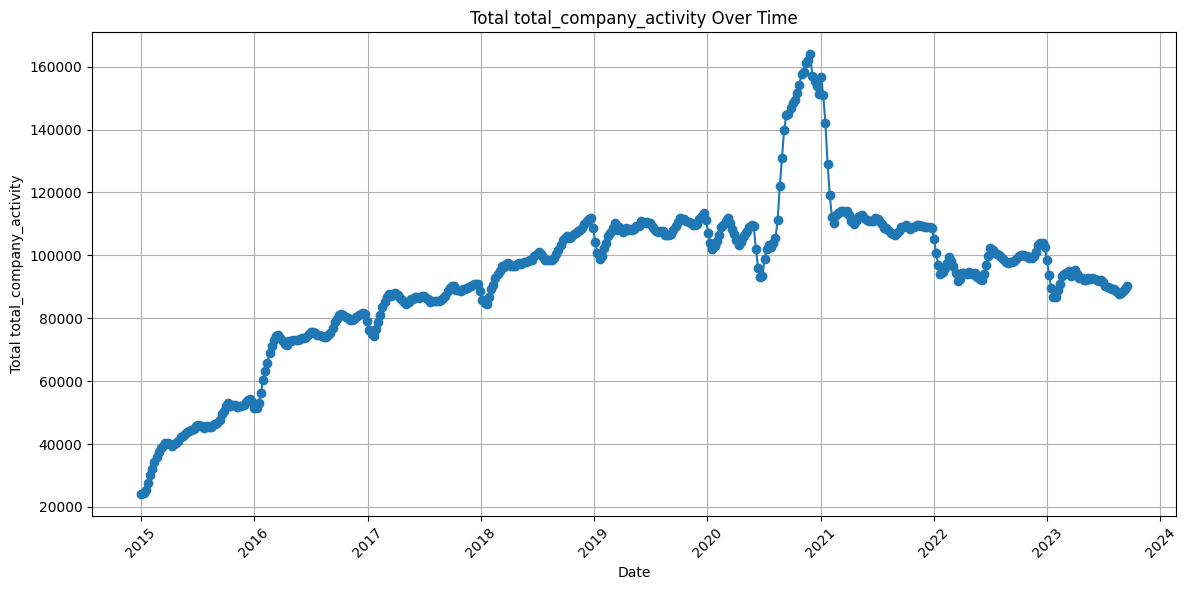

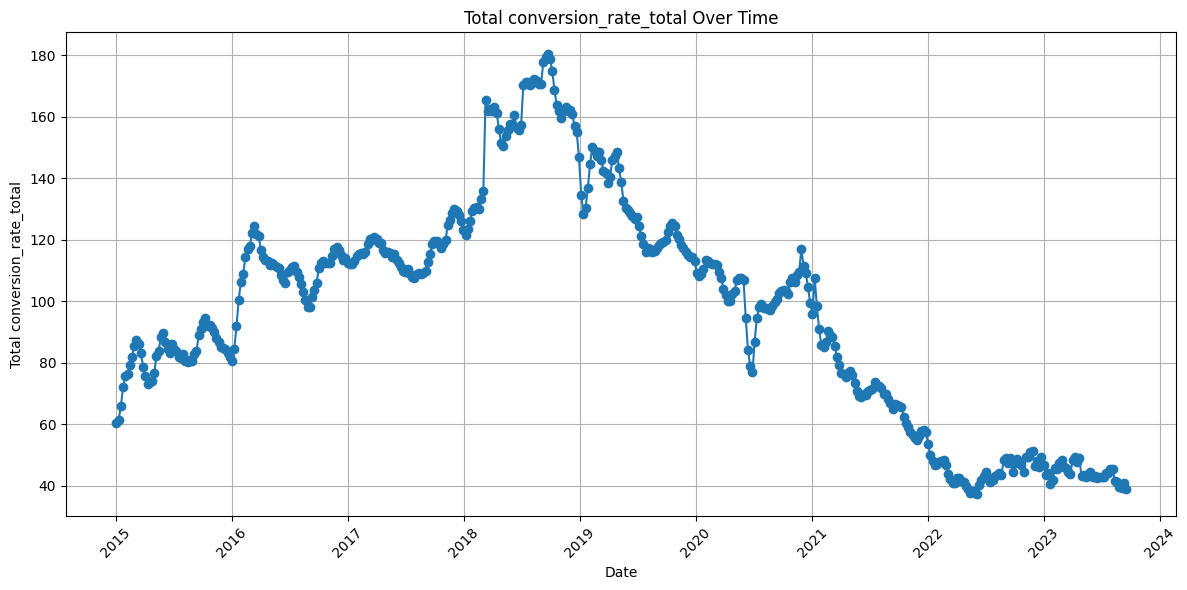

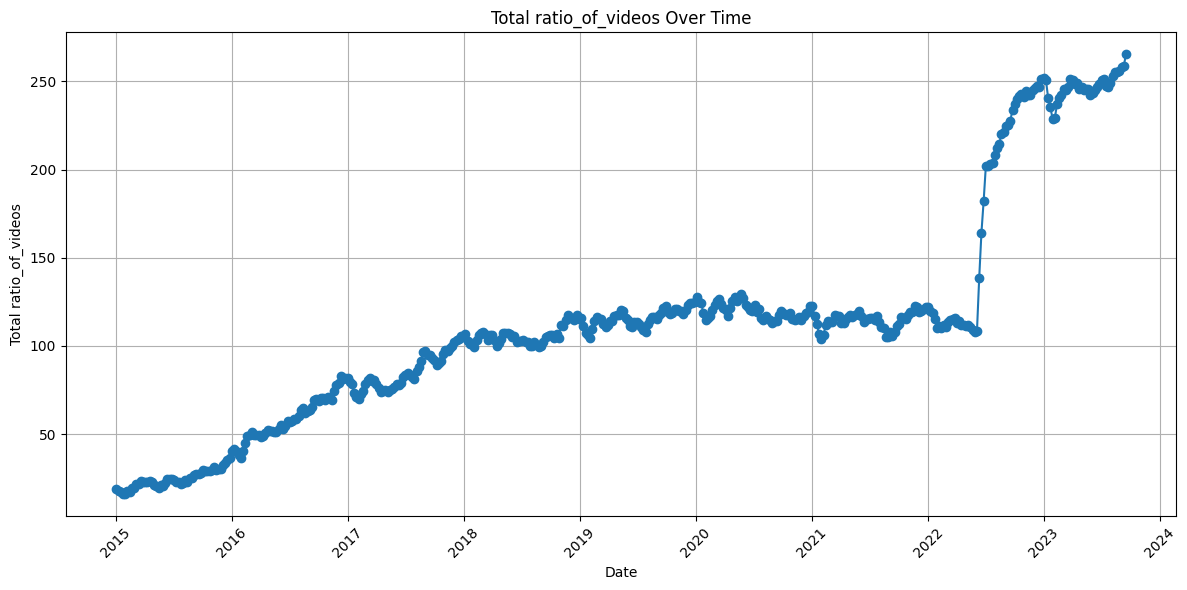

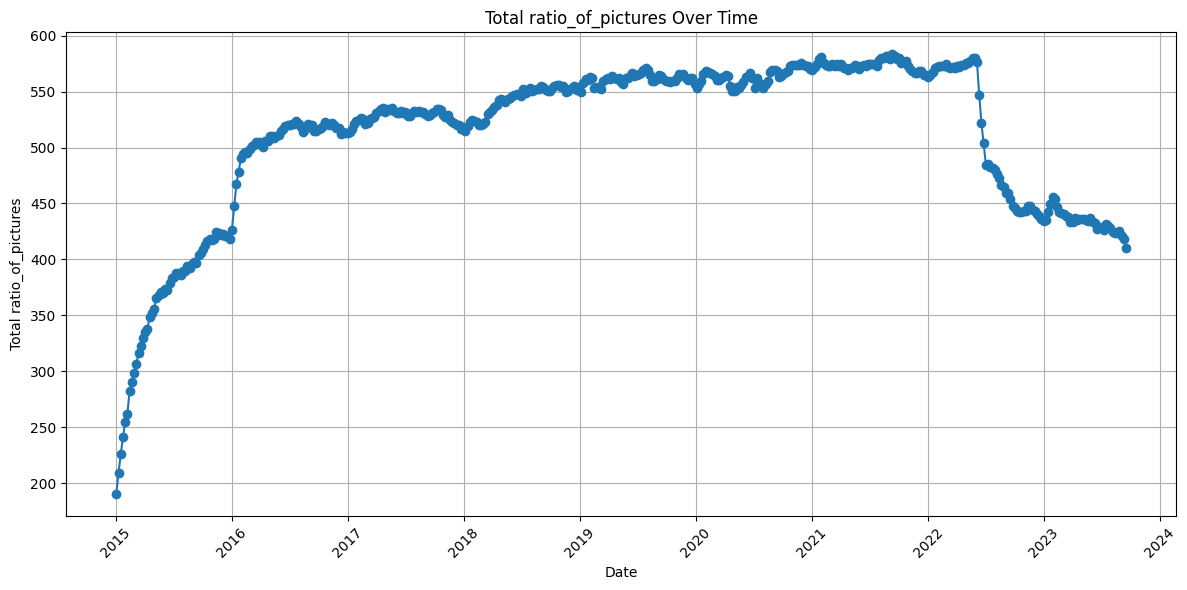

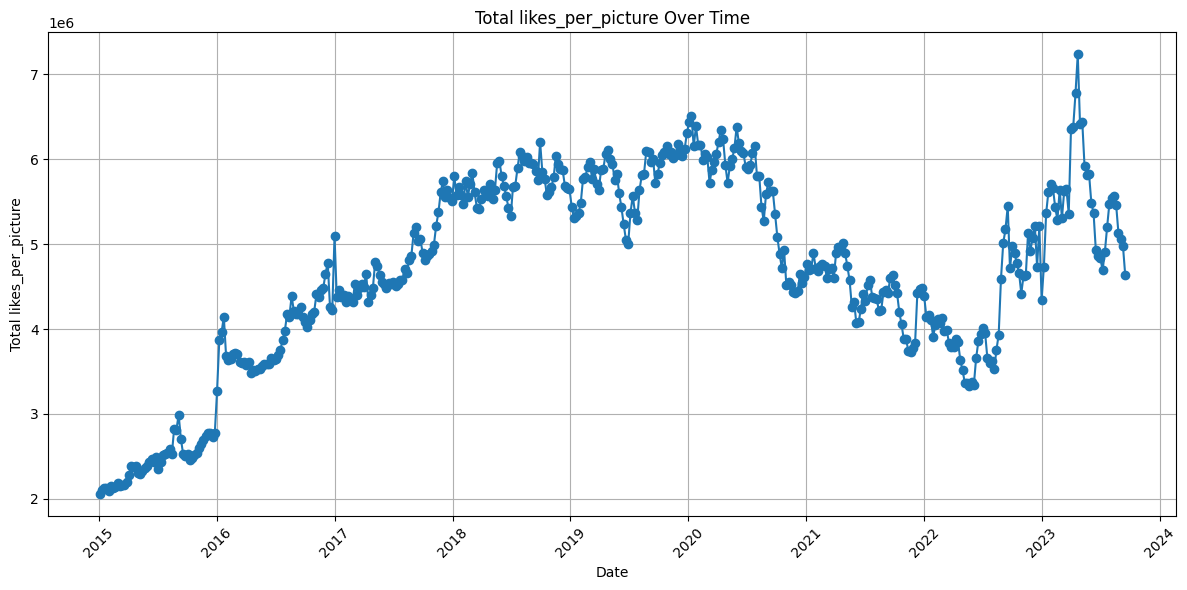

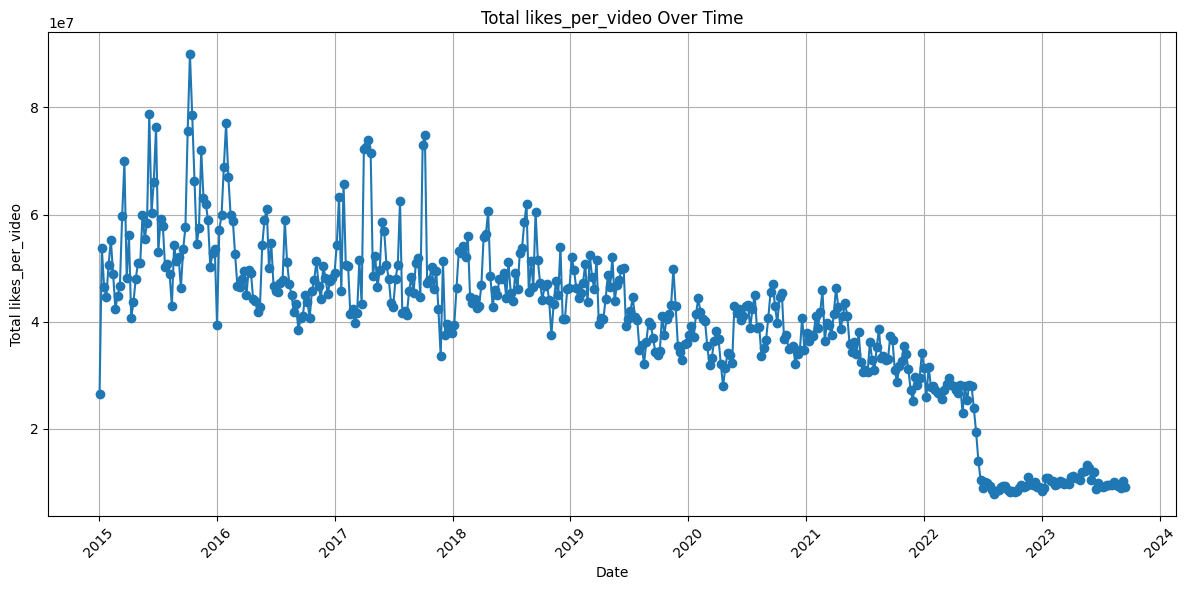

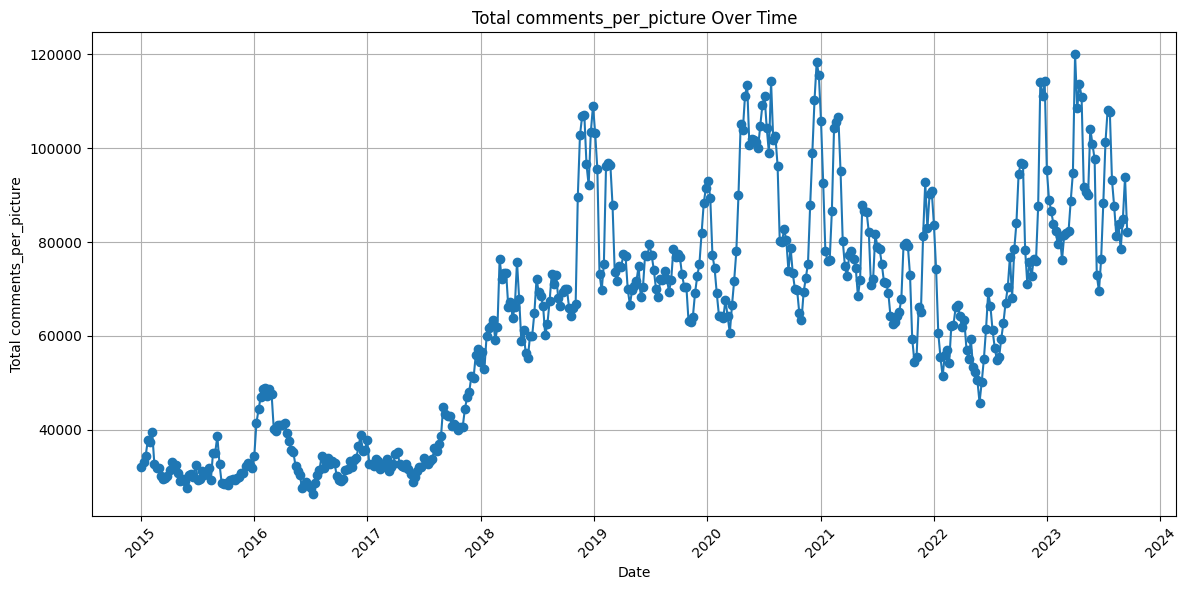

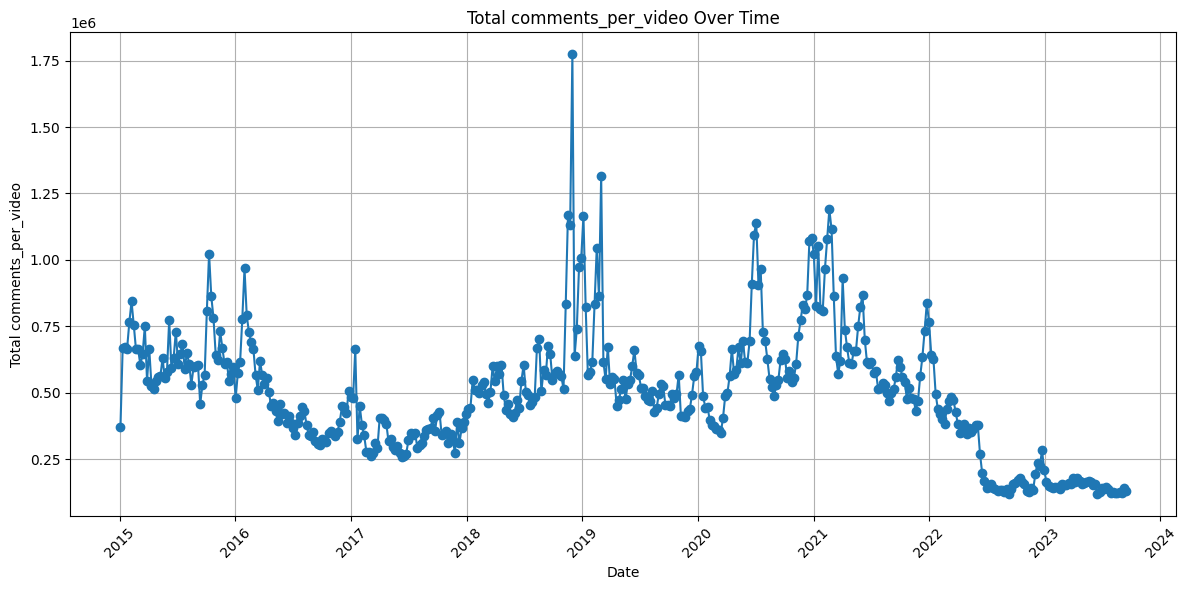

In [19]:
reload(plots)
for agg in agg_by:
    plots.total_aggregate(df, agg)